## Imports

The $AR(p)$ model is purely written with numpy.

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.animation as animation
from scipy import special

rng = np.random.default_rng(11)

### Auxilary functions

In [4]:
def plot_data(data):

    plt.figure(1, figsize=(16,4))
    plt.plot(data)
    plt.xlim(len(data[:50000]), len(data))
    
    return True

def plot_2d_data(data, title=""):


    threshold = 0.5
    # Plotting the distribution of wind velocities
    root = int(len(data)**(1/2))
    root_data = np.array(data[:root**2]).reshape(root,root)

    
    # Normalizing
    root_data /= np.max(root_data)

    wind_gusts = np.where(root_data>threshold, 1, 0)
    #root_data **= 2
    root_data = np.exp(root_data)

    # Plotting
    fig, axs = plt.subplots(1,3, figsize=(16,4))
    axs[0].imshow(root_data, cmap="gray")
    axs[0].set_title("Wind fluctuations")

    axs[1].imshow(wind_gusts, cmap="gray")
    axs[1].set_title(f"Wind fluctuations over {threshold*100:.0f}%")

    axs[2].hist(data, bins=20)
    axs[2].set_yscale("log")
    axs[2].set_title("Probability density $p_x$")
    
    fig.suptitle(f"{title}")

    return True

### Create Surrogated Data

The surrogated dataset is only used to validate the functionality of the $AR(p)$ model. The dataset is created using itself an $AR(p=3)$ model with predefined coefficients $\phi_{1...3}$ The model should derive the right coefficients back from drawing statistical inferences from the dataset.

$\displaystyle AR(x_t)=\phi_1x_{t-1}+\phi_2x_{t-2}+\phi_3x_{t-3}+w_t$

In [5]:
def create_artificial_data(n_data=2e+6):

    # Random start data
    data = [1, 0, -1]
    ar_coefficients = [0.4, 0.2, 0.15]

    for _ in range(int(n_data)):
        white_noise = rng.standard_normal()
        result = sum([x*p for x, p in zip(reversed(data), ar_coefficients)])
        result += white_noise
        data.append(result)
        
    return np.array(data)

surrogated_data = create_artificial_data()

### Load Data

Loads the FINO1 wind velocity data.

In [6]:
DIRNAME = os.path.abspath("")
PLOTS_PATH = os.path.join(DIRNAME, "Plots")
DATA_DIR = os.path.join(os.path.dirname(DIRNAME), "FINO1Data")
#ANI_PATH = os.path.join(PLOTS_PATH, "Animation")
#DAILY_PATH = os.path.join(PLOTS_PATH, "DailyPDF")

os.makedirs(PLOTS_PATH, exist_ok=True)
#os.makedirs(DAILY_PATH, exist_ok=True)
#os.makedirs(ANI_PATH, exist_ok=True)

datasets = {path.replace(".npy", ""): np.load(os.path.join(DATA_DIR, path), allow_pickle=True) for path in os.listdir(DATA_DIR) if path.endswith("npy")}

In [7]:
# Surrogated data is already stationary
datasets["surrogated data"] = surrogated_data

#### Lerp (linear interpolation)

Gets rid of the NaN's by replacing them with a linear line.

In [8]:
# Implementing Lerp (linear interpolation)
def lerp(data):
    
    ok = ~np.isnan(data)
    xp = ok.nonzero()[0]
    fp = data[ok]
    x = np.isnan(data).nonzero()[0]
    data[~ok] = np.interp(x, xp, fp)

    return data

### Pre-Analysis

General statistics of the datasets, probability density

In [9]:
for key, dataset in datasets.items():

    print(f"Dataset: {key}")
    print(f"NaNs: {np.isnan(dataset).sum()}")
    print("\n")

Dataset: 2015-2017_90m
NaNs: 183884


Dataset: 1509_100m
NaNs: 2633


Dataset: 1509_60m
NaNs: 2633


Dataset: 2015-2017_60m
NaNs: 54537


Dataset: 2015-2017_100m
NaNs: 54578


Dataset: 1509_30m
NaNs: 1908


Dataset: 2015-2017_30m
NaNs: 183887


Dataset: surrogated data
NaNs: 0




In [140]:

# n = len(datasets["2015-2017_100m"])
# d = 60*60*24
# l = int(n/d)
# print(l)
# for i in range(l):
#     plt.close()
#     plt.hist(datasets["2015-2017_100m"][d*i:d*(i+1)], bins=50)
#     plt.xlim(0,25)
#     #plt.savefig(os.path.join(Daily_PDF, f"PDF{i}.png"), format="png")

## 2D Histogram

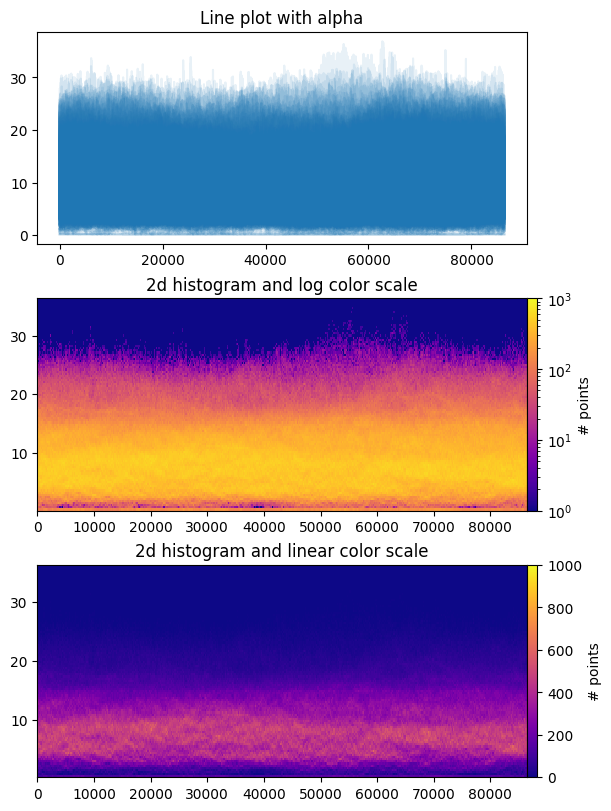

In [137]:
# from copy import copy

# import numpy as np
# import numpy.matlib
# import matplotlib.pyplot as plt
# from matplotlib.colors import LogNorm

# fig, axes = plt.subplots(nrows=3, figsize=(6, 8), layout='constrained')


# x = np.arange(d)
# y = np.array([datasets["2015-2017_100m"][d*i:d*i+d] for i in range(l-1)])


# axes[0].plot(x, y.T, color="C0", alpha=0.1)
# axes[0].set_title("Line plot with alpha")


# # Now we will convert the multiple time series into a histogram. Not only will
# # the hidden signal be more visible, but it is also a much quicker procedure.
# # Linearly interpolate between the points in each time series
# num_fine = 10000
# x_fine = np.linspace(x.min(), x.max(), num_fine)
# y_fine = np.empty((l-1, num_fine), dtype=float)
# for i in range(l-1):
#     y_fine[i, :] = np.interp(x_fine, x, y[i, :])
# y_fine = y_fine.flatten()
# x_fine = np.matlib.repmat(x_fine, l-1, 1).flatten()


# # Plot (x, y) points in 2d histogram with log colorscale
# # It is pretty evident that there is some kind of structure under the noise
# # You can tune vmax to make signal more visible
# cmap = copy(plt.cm.plasma)
# cmap.set_bad(cmap(0))
# h, xedges, yedges = np.histogram2d(x_fine, y_fine, bins=[400, 100])

# pcm = axes[1].pcolormesh(xedges, yedges, h.T, cmap=cmap,
#                          norm=LogNorm(vmax=1e3), rasterized=True)

# fig.colorbar(pcm, ax=axes[1], label="# points", pad=0)
# axes[1].set_title("2d histogram and log color scale")

# # Same data but on linear color scale
# pcm = axes[2].pcolormesh(xedges, yedges, h.T, cmap=cmap,
#                          vmax=1e3, rasterized=True)

# fig.colorbar(pcm, ax=axes[2], label="# points", pad=0)
# axes[2].set_title("2d histogram and linear color scale")

# plt.show()

In [10]:
# Removing NaNs with linear interpolation
datasets = {key: lerp(value) for key, value in datasets.items()}

In [11]:
# Statistics of wind data
for key, dataset in datasets.items():

    print(f"Dataset: {key}: ")
    print(f"Max velocity: {dataset.max():.4f}")
    print(f"Min velocity: {dataset.min():.4f}")
    print(f"Length of dataset: {len(dataset)}")
    print("\n")

Dataset: 2015-2017_90m: 
Max velocity: 36.2131
Min velocity: 0.1830
Length of dataset: 52531200


Dataset: 1509_100m: 
Max velocity: 26.1070
Min velocity: 0.1840
Length of dataset: 2592000


Dataset: 1509_60m: 
Max velocity: 26.1858
Min velocity: 0.1870
Length of dataset: 2592000


Dataset: 2015-2017_60m: 
Max velocity: 34.9993
Min velocity: 0.1700
Length of dataset: 52531200


Dataset: 2015-2017_100m: 
Max velocity: 36.8618
Min velocity: 0.1840
Length of dataset: 52531200


Dataset: 1509_30m: 
Max velocity: 23.3325
Min velocity: 0.1900
Length of dataset: 2592000


Dataset: 2015-2017_30m: 
Max velocity: 33.9669
Min velocity: 0.1900
Length of dataset: 52531200


Dataset: surrogated data: 
Max velocity: 6.7782
Min velocity: -6.7078
Length of dataset: 2000003




The differentiation of the time series $v_t$ and $v_{t+1}$ leads to a time series of wind fluctuations $u_t$:

$\displaystyle u_t=v_{t+1}-v_t$

The probability density $p_u$ of $u_t$ is a stretched-exponential-distribution.

In [12]:
# Differentiation to make data stationary
datasets = {key: dataset[1:] - dataset[:-1] for key, dataset in datasets.items()}

In [13]:
for key, dataset in datasets.items():

    print(f"Dataset: {key}: ")
    print(f"Max fluctuation: {dataset.max():.4f}")
    print(f"Min fluctuation: {dataset.min():.4f}")
    print("\n")

Dataset: 2015-2017_90m: 
Max fluctuation: 15.2161
Min fluctuation: -14.9254


Dataset: 1509_100m: 
Max fluctuation: 4.0584
Min fluctuation: -3.8555


Dataset: 1509_60m: 
Max fluctuation: 7.2472
Min fluctuation: -7.2472


Dataset: 2015-2017_60m: 
Max fluctuation: 14.2411
Min fluctuation: -13.5822


Dataset: 2015-2017_100m: 
Max fluctuation: 17.2853
Min fluctuation: -16.8069


Dataset: 1509_30m: 
Max fluctuation: 6.3806
Min fluctuation: -6.7351


Dataset: 2015-2017_30m: 
Max fluctuation: 12.3395
Min fluctuation: -12.6950


Dataset: surrogated data: 
Max fluctuation: 6.2841
Min fluctuation: -5.9599




In [14]:
# Active dataset
dname = "2015-2017_100m"
dataset = datasets[dname]

#### Splitting the Dataset

In [15]:
# Split
test_set_size = min(1000000, int(len(dataset) * 0.5))
train_data = dataset[:-test_set_size]
test_data = dataset[-test_set_size:]

print(f"Split up the dataset into {len(train_data)} training examples and {len(test_data)} testing examples.")

Split up the dataset into 51531199 training examples and 1000000 testing examples.


## $AR(p)$ Model

#### Autocovariance

The autocovariance is the covariance of a time series with itself and with another time point with itself $x_t$ and $x_{t+\tau}$. Here, $\tau$ is the lag.

$\displaystyle Cov({x_t,x_{t+\tau}})=(x_t-\mu_x)(x_{t+\tau}-\mu_x)$

In [16]:
def autocovariance(data, lag):
    
    cov = (data)[lag:] * (data)[:-lag]
    return cov.mean()


#### Autocorrelation function

Hereby $\gamma_x(\tau)$ is the autocovariance of every point with lag $\tau$.

$\displaystyle \rho(t_1,t_2)=\rho(\tau)=\frac{\gamma(\tau)}{\gamma(0)}$

In [145]:
def get_phis2(data, p, train_per):
    
    # TODO Implement substract mean
    #means = np.convolve(data, np.ones(train_per), "valid") / train_per
    #data = data[train_per: -train_per] - means

    indices =  np.arange(train_per)[:, None] + np.arange(0, len(data)-train_per)
    stds = data[indices].std(axis=0) ** 2
  
    z = [np.array(data[lag:] * data[:-lag])[:lag-(p+1)] for lag in range(1, p+1)]

    acfs = [(np.convolve(z[lag], np.ones(train_per-(lag+1)), "valid") / (train_per-(lag+1)))[:-(lag+1)] for lag in range(p)]
    acfs = [acf / stds[:-p] for acf in acfs]

    acfs.insert(0, np.ones_like(acfs[0]))
    acfs = np.stack(acfs)
    
    matrix_mask = np.array([abs(-k+j) for k in range(p) for j in range(p)])
    matrices = acfs[matrix_mask, :].reshape(p,p,-1).T
    
    det_mask = np.linalg.det(matrices)
    zero_det = np.where(det_mask == 0., True, False)
    matrices[zero_det, 0] += 1e-8   
    
    phis = np.linalg.solve(matrices, acfs[1:].T)


    return np.array(phis)


In [92]:
np.set_printoptions(suppress=True)
phis = get_phis2(train_data[:], p=3, train_per=10)

/var/folders/q5/4fw43q7s02j4ymzfzqf9t82c0000gn/T/ipykernel_47146/108001354.py:13: RuntimeWarning: divide by zero encountered in divide
  acfs = [acf / stds[:-p] for acf in acfs]
/var/folders/q5/4fw43q7s02j4ymzfzqf9t82c0000gn/T/ipykernel_47146/108001354.py:13: RuntimeWarning: invalid value encountered in divide
  acfs = [acf / stds[:-p] for acf in acfs]


In [153]:
indices = np.arange(9, len(train_data))[:, None] - np.arange(3)
x = train_data[indices]

res = x[:-4] * phis
res = res.sum(axis=1)

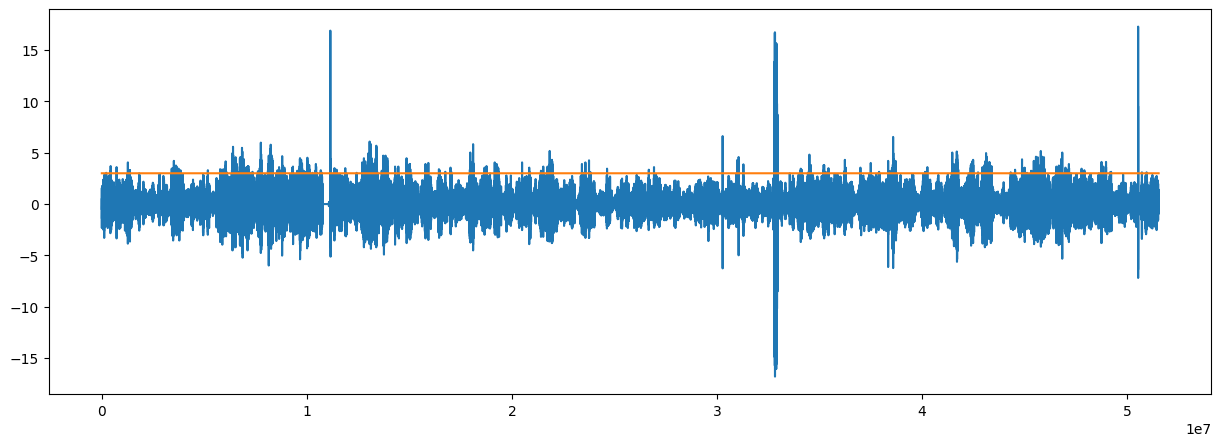

In [125]:
_ = plt.figure(figsize=(15,5))
plt.plot(train_data)
plt.plot(np.ones(len(train_data))*3)

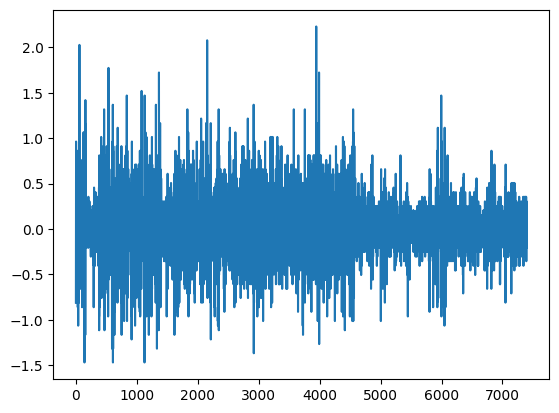

In [179]:
plt.plot(train_data[33092600:33100000])

(-3.0, 3.0)

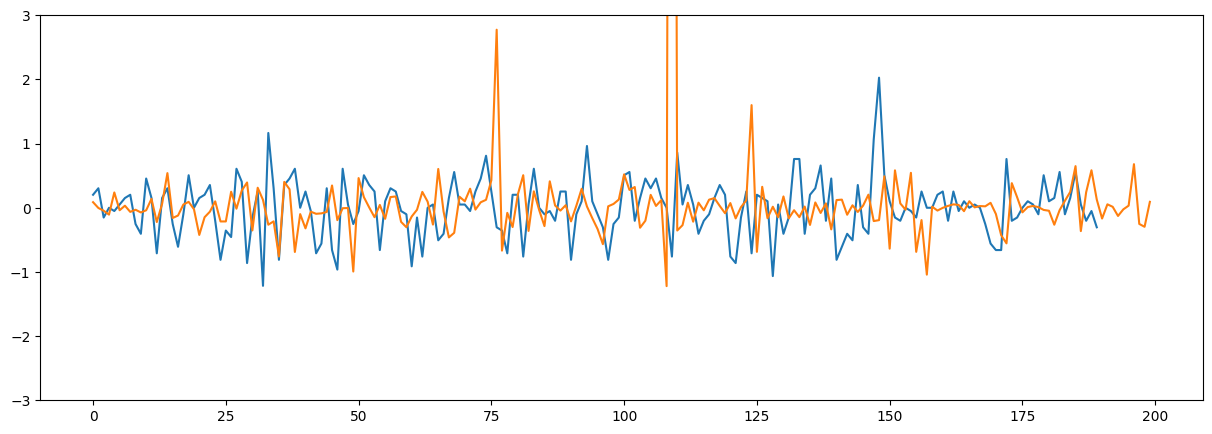

In [182]:
_ = plt.figure(figsize=(15,5))
n = 33092500
plt.plot(train_data[n+10:n+200])
plt.plot(res[n:n+200])
plt.ylim(-3,3)

### Animation

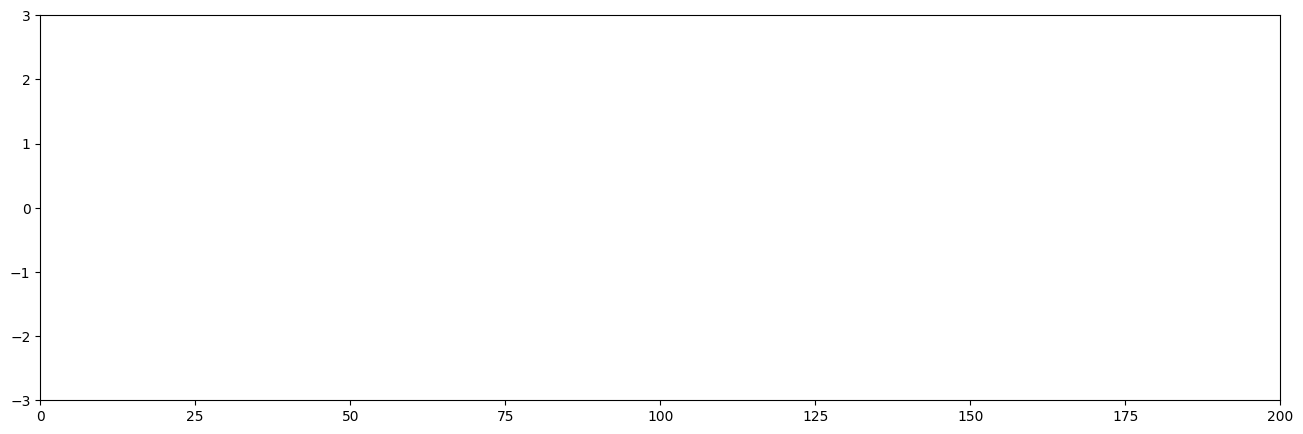

In [24]:
n = 100000

x1 = train_data[n-3:n+200-3]
res1 = res[n:n+200-10]

t = np.arange(190)


fig, ax = plt.subplots(figsize=(16,5))

line1 = ax.plot(x1[0])[0]
line2 = ax.plot(res1[1])[0]


ax.set(xlim=[0,200], ylim=[-3,3])


def update(frame):
    line1.set_xdata(t[:frame])
    line1.set_ydata(x1[:frame])
    line2.set_xdata(t[:frame])
    line2.set_ydata(res1[:frame])
    return (line1, line2)


ani = animation.FuncAnimation(fig=fig, func=update, frames=190, interval=60)
plt.show()

#ani.save(filename=os.path.join(ANI_PATH, f"{dname}.gif"), writer="pillow")


In [25]:
p = 3
lags = range(1, p+1)

def get_phis(data):

    # Autocorrelation function + addition of an error value
    acf = [autocovariance(data, lag) / (data.std()**2) for lag in lags]

    # Yule-Walker equation with autocorrelation function
    acf.insert(0, 1.)
    r = [acf[abs(-k+j)] for k in range(p) for j in range(p)]
    acf.pop(0)
    matrix = (np.array(r).reshape(p, p))
    inv_matrix = np.linalg.inv(matrix)
    phi_hats = inv_matrix @ np.array(acf).reshape(p, 1)

    return phi_hats.flatten()

get_phis(train_data)

array([ 0.00423598, -0.12918999, -0.06833812])

When the time series is not stationary: $\hat{\phi}_1$ is close to 1, whereas $\hat{\phi}_{others}$ are close to 0. This means that the next time step is almost completly determind by $x_{t-1}$.

## MA($q$) Model 

$\displaystyle SMA=\frac{1}{k}\sum_{i=t-k+1}^tx_i$

$\displaystyle {SMA}_{k, next} = SMA_{k, prev} + \frac{1}{k}\left(x_{t+1}-x_{t-k+1}\right)$ but we are using convolutions instead

In [26]:
def get_sma(data, q=3):
 
    ok = ~np.isnan(data)
    data[~ok] = .0
    denominators = np.convolve(ok, np.ones(q), "valid")
    #denominators[~(denominators>0)] += 1

    sma = np.convolve(data, np.ones(q), "valid")
    sma /= denominators

    return sma

get_sma(np.array([1,2,3,np.nan, np.nan, np.nan, np.nan, 4, 5]))

/var/folders/q5/4fw43q7s02j4ymzfzqf9t82c0000gn/T/ipykernel_5158/1040066021.py:9: RuntimeWarning: invalid value encountered in divide
  sma /= denominators


array([2. , 2.5, 3. , nan, nan, 4. , 4.5])

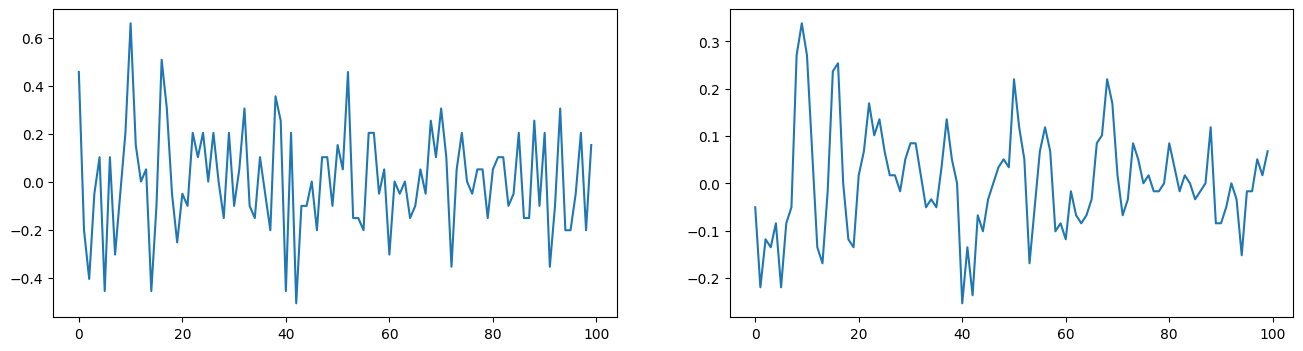

In [27]:
_, (ax1, ax2) = plt.subplots(1,2, figsize=(16,4))

ax1.plot(train_data[:100])
ax2.plot(get_sma(train_data)[:100])

## Model Forecast

In [34]:
train_per = 120
gust_th = 1.6
q = 3 # moving average

n = len(train_data)
l = p # overlap size

In [35]:
def make_intervals(data):
    start_indices = np.arange(0, n-train_per-l, train_per) 
    indices = start_indices[:, None] + np.arange(train_per+l)
    intervals = data[indices]
    
    return intervals

smoothed_train_intervals = make_intervals(train_data)
train_intervals = make_intervals(train_data)

print(f"Train intervals shape: {train_intervals.shape}")
print(f"Smoothed        shape: {smoothed_train_intervals.shape}")

Train intervals shape: (429426, 123)
Smoothed        shape: (429426, 123)


$AR(p) = \phi_1x_{t-1}+\phi_2x_{t-2}+\phi_3x_{t-3}+{\color{yellow}{w(t)}}$

$w(t) \sim \mathcal{N}(\mu=0, \sigma_w^2)$

In [36]:
stds = train_intervals[:-1].std(axis=1)
white_noise = rng.normal(size=train_intervals[:-1, l:].shape, scale=(stds**2)[:, None])

In [37]:
print(stds.mean())
print(white_noise.min())
print(white_noise.max())
((2*stds**2)**0.5).mean()

0.2959667099363362
-16.010540490663395
17.143432305329902


0.4185601352029104

In [38]:
phi_hats = get_phis(train_intervals[0])
predictions = []

for x in smoothed_train_intervals[1:]:
    prediction = np.convolve(x[:-1], phi_hats, "valid")
    predictions.append(prediction)
    phi_hats = get_phis(x)
    
predictions = np.array(predictions)

/var/folders/q5/4fw43q7s02j4ymzfzqf9t82c0000gn/T/ipykernel_5158/3428190871.py:7: RuntimeWarning: invalid value encountered in double_scalars
  acf = [autocovariance(data, lag) / (data.std()**2) for lag in lags]


In [39]:
predictions += white_noise

Text(0, 0.5, 'fluctuation in (m/s)')

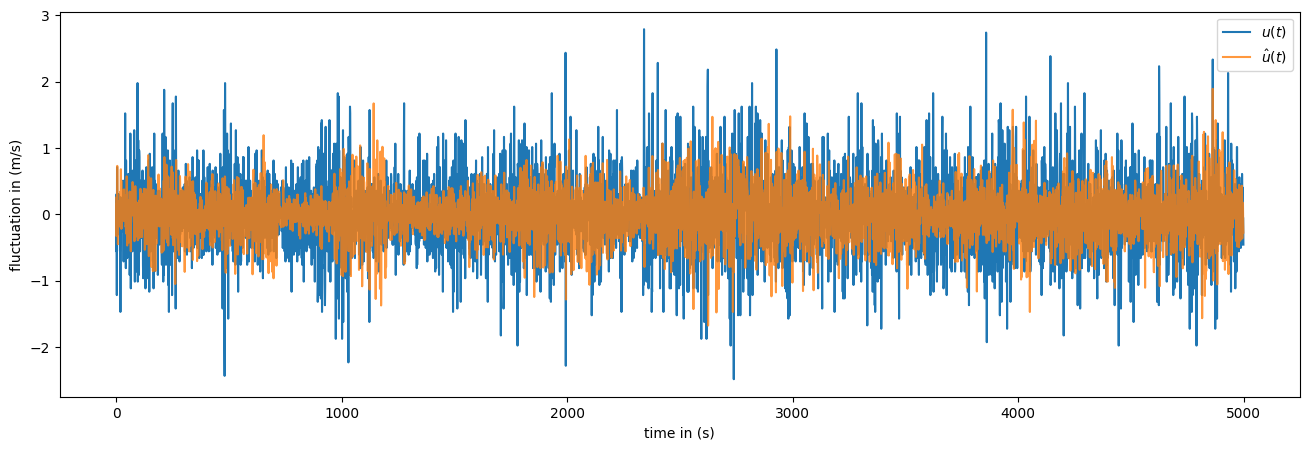

In [40]:
value = 420000
_ = plt.figure(1, figsize=(16,5))
plt.plot(train_intervals[1:, l:].flatten()[value:value+5000], label="$u(t)$")
plt.plot(predictions.flatten()[value:value+5000], alpha=0.8, label="$\hat{u}(t)$")
plt.legend()
plt.xlabel("time in (s)")
plt.ylabel("fluctuation in (m/s)")

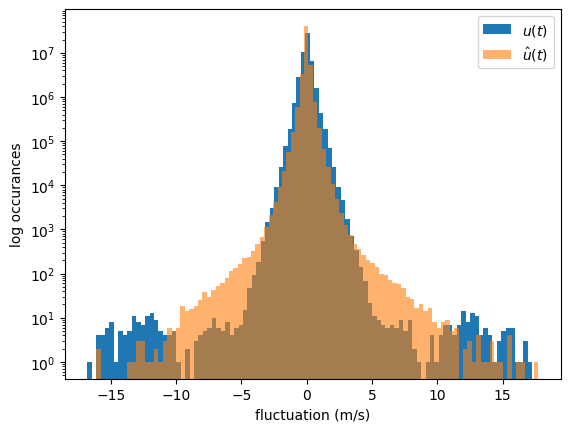

In [41]:
plt.hist(train_intervals[1:, l:].flatten(), bins=100, label="$u(t)$");
plt.hist(predictions.flatten(), bins=100, label="$\hat{u}(t)$", alpha=0.6);
plt.legend()
plt.xlabel("fluctuation (m/s)")
plt.ylabel("log occurances")
plt.yscale("log")

In [42]:
n_gusts = np.where(train_intervals[1:, l:].flatten() > gust_th, 1, 0).sum()
n_gusts

111857

In [43]:
n_gusts = np.where(predictions.flatten() > gust_th, 1, 0).sum()
n_gusts

36330

The integral of the Gaussian bell is called $\operatorname{erf(x)}$. 

$\displaystyle P\left(\hat{u}(t)> u_x\right)=\frac{1}{2}\left[1-\operatorname{erf}\left(\frac{u_x-\hat{u}(t)}{\sqrt{2\sigma_w^2(t)}}\right)\right]$

In [46]:
z = (gust_th - predictions) / ((2*stds**2)**0.5)[:, None]
pred_integral = 0.5 * (1 - special.erf(z))

In [47]:
np.argmax(pred_integral.max(axis=1))

15916

Text(0, 0.5, 'Exceeding probability: $P(\\hat{u}(t)>u_x)$')

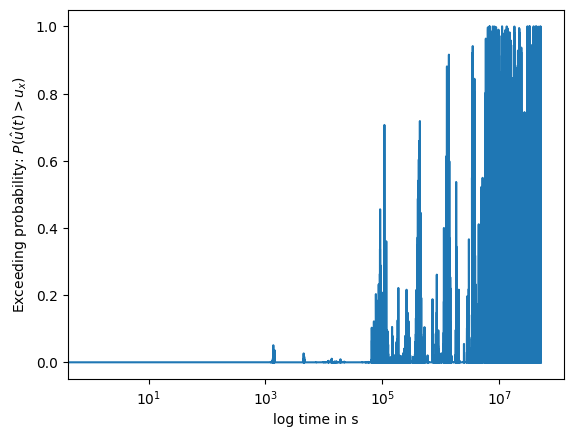

In [48]:
plt.semilogx(pred_integral.flatten())
plt.xlabel("log time in s")
plt.ylabel("Exceeding probability: $P(\hat{u}(t)>u_x)$")

Text(0, 0.5, 'Log occurances')

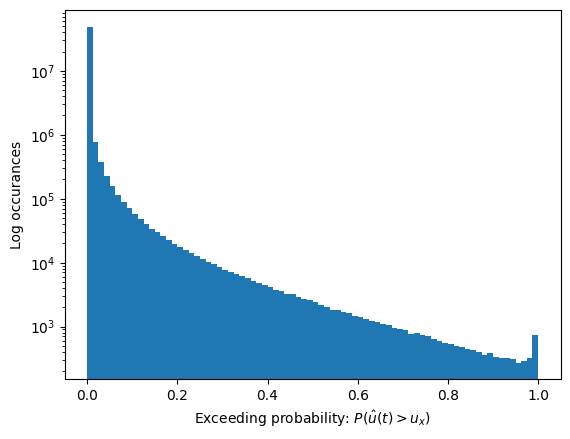

In [49]:
pred_integral = pred_integral.flatten()
plt.hist(pred_integral, bins=80);
plt.yscale("log")
plt.xlabel("Exceeding probability: $P(\hat{u}(t)>u_x)$")
plt.ylabel("Log occurances")

$\displaystyle G(t) = \begin{cases} 3 & u(t) > u_x \\ 1 & u(t) < u_x \end{cases}$

$P\left(\hat{u}(t) > u_x\right)$


$\displaystyle \hat{G}(t) = \begin{cases} 1 & Q > 0.75 \\ 0 & Q < 0.75\end{cases}$

In [50]:
np.argmax(train_intervals[1:, l:].max(axis=1))

421103

In [51]:
quantiles = 1/np.exp(np.linspace(0, 40, 20))[::-1]
wind_gusts = np.where(train_intervals[1:, l:].flatten() >= gust_th, 3, 0) # G(t)
n_gusts = np.where(wind_gusts == 3, 1, 0).sum()

print(f"Total wind gusts: {n_gusts}")

Total wind gusts: 111857


## ROC-curve (Receiver operating characteristic-curve) 1

In [52]:
# OLD VERSION
thresholds = np.linspace(-0.8, 1.5, 20)
performances = dict.fromkeys(thresholds)

for threshold in thresholds:


    # Model prediction: wind gust
    wind_gusts_pred = np.where(predictions.flatten() >= threshold, 1, 0)

    true_positive = np.where(wind_gusts_pred + wind_gusts == 4, 1, 0)
    false_positive = np.where(wind_gusts_pred + wind_gusts == 1, 1, 0)
    
    true_positive_rate = true_positive.sum() / n_gusts
    false_positive_rate = false_positive.sum() / (len(wind_gusts)-n_gusts)
    
    performances[threshold] = (true_positive_rate, false_positive_rate)

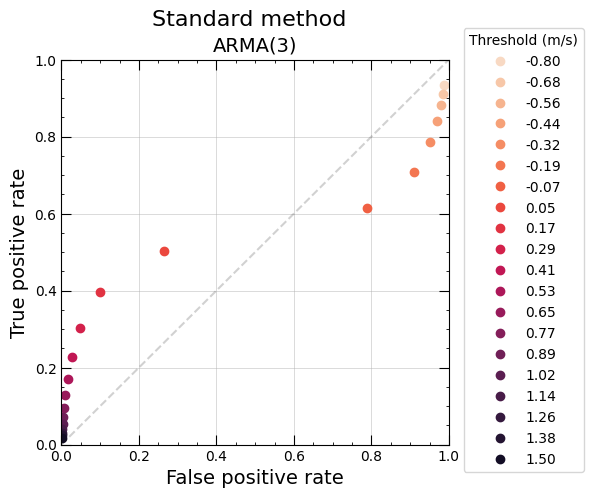

In [54]:
colors = sns.color_palette("rocket_r", len(performances))

fig = plt.figure(1, figsize=(5,5))

i = 0
for threshold, (true_positive_rate, false_positive_rate) in performances.items():
    plt.plot(false_positive_rate, true_positive_rate, "o", label=f"{threshold:.2f}", color=colors[i])
    i += 1
plt.plot(np.arange(2), linestyle="--", color='#0f0f0f30')


plt.grid(linewidth=0.4, alpha=0.8)
plt.xlim(0,1)
plt.ylim(0,1)

plt.minorticks_on()
plt.tick_params(direction="in", which="major", length=7, bottom=True, top=True, right=True)
plt.tick_params(direction="in", which="minor", length=2.5, bottom=True, top=True, right=True)
plt.xlabel("False positive rate", fontsize=14)
plt.ylabel("True positive rate", fontsize=14)

plt.title(f"ARMA({p})", fontsize=14)
plt.suptitle("Standard method", fontsize=16)
plt.legend(title="Threshold (m/s)", fontsize=10, bbox_to_anchor=(1.02,1.1))

plt.savefig(os.path.join(PLOTS_PATH, f"{dname}-tau={train_per}-Standard-AR({p}).png"), format="png", dpi=300, bbox_inches="tight")

## ROC-curve (Receiver operating characteristic-curve) 2

In [55]:
performances2 = dict.fromkeys(quantiles)

for quantile in quantiles:

    wind_gusts_pred = np.where(pred_integral >= quantile, 1, 0) 

    true_positive = np.where(wind_gusts_pred + wind_gusts == 4, 1, 0)
    false_positive = np.where(wind_gusts_pred + wind_gusts == 1, 1, 0)
    
    true_positive_rate = true_positive.sum() / n_gusts
    false_positive_rate = false_positive.sum() / (len(wind_gusts) - n_gusts)

    performances2[quantile] = (true_positive_rate, false_positive_rate)


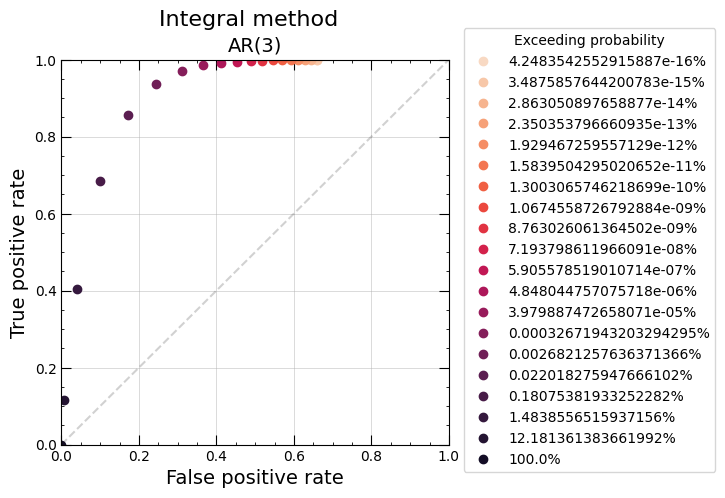

In [56]:
colors = sns.color_palette("rocket_r", len(performances2))

fig = plt.figure(1, figsize=(5,5))

i = 0
for threshold, (true_positive_rate, false_positive_rate) in performances2.items():
    plt.plot(false_positive_rate, true_positive_rate, "o", label=f"{quantiles[i]*100}%", color=colors[i])
    i += 1
plt.plot(np.arange(2), linestyle="--", color='#0f0f0f30')


plt.grid(linewidth=0.4, alpha=0.8)
plt.xlim(0,1)
plt.ylim(0,1)

plt.minorticks_on()
plt.tick_params(direction="in", which="major", length=7, bottom=True, top=True, right=True)
plt.tick_params(direction="in", which="minor", length=2.5, bottom=True, top=True, right=True)
plt.xlabel("False positive rate", fontsize=14)
plt.ylabel("True positive rate", fontsize=14)

plt.title(f"AR({p})", fontsize=14)
plt.suptitle("Integral method", fontsize=16)
plt.legend(title="Exceeding probability", fontsize=10, bbox_to_anchor=(1.02,1.1))

plt.savefig(os.path.join(PLOTS_PATH, f"{dname}-tau={train_per}Integral-AR({p}).png"), format="png", dpi=300, bbox_inches="tight")

## Calculating the best $\mathcal{Q}_{\tau}(t)$ using $\Xi$

In [57]:
base_1 = np.array([.5,-.5])
base_2 = np.array([.5, .5])

points = dict()

for key, (y,x) in performances2.items():
    point = x * base_1 + y * base_2
    points[key] = point


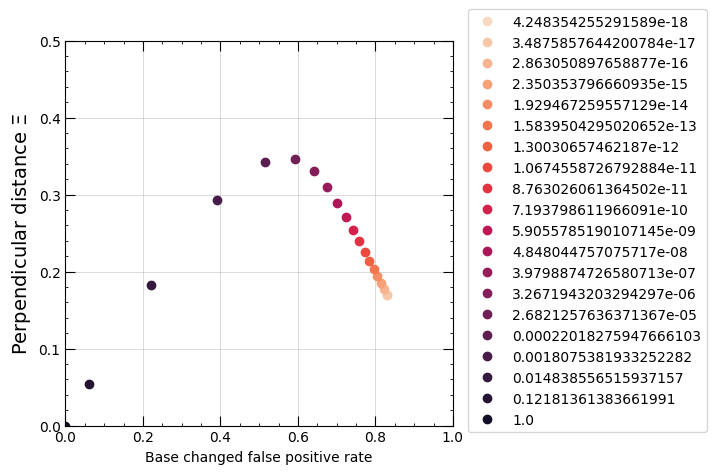

In [58]:
_ = plt.figure(figsize=(5,5))
i = 0
for threshold, (y,x) in points.items():
    plt.plot(y, x, "o", label=f"{quantiles[i]}", color=colors[i])
    i += 1

plt.plot(np.ones(2)*0.5, linestyle="--", color='#0f0f0f30')
plt.grid(linewidth=0.4, alpha=0.8)
plt.ylim(0,0.5)
plt.xlim(0,1)
plt.minorticks_on()
plt.tick_params(direction="in", which="major", length=7, bottom=True, top=True, right=True)
plt.tick_params(direction="in", which="minor", length=2.5, bottom=True, top=True, right=True)
plt.xlabel("Base changed false positive rate", fontsize=10)
plt.ylabel("Perpendicular distance $\Xi$", fontsize=14)
plt.legend(fontsize=10, bbox_to_anchor=(1.02,1.1))

In [59]:
dict(reversed(sorted(points.items(), key=lambda item:item[1][1])))

{2.6821257636371367e-05: array([0.59124773, 0.34630647]),
 0.00022018275947666103: array([0.51461643, 0.34262988]),
 3.2671943203294297e-06: array([0.64050727, 0.33057188]),
 3.9798874726580713e-07: array([0.67517362, 0.30966416]),
 0.0018075381933252282: array([0.39222801, 0.29339739]),
 4.848044757075717e-08: array([0.70189362, 0.2891664 ]),
 5.9055785190107145e-09: array([0.72388578, 0.27066082]),
 7.193798611966091e-10: array([0.74226935, 0.25399373]),
 8.763026061364502e-11: array([0.75806909, 0.23919527]),
 1.0674558726792884e-11: array([0.77195302, 0.22603548]),
 1.30030657462187e-12: array([0.78415371, 0.21417451]),
 1.5839504295020652e-13: array([0.79506427, 0.20355003]),
 1.929467259557129e-14: array([0.80485533, 0.19400929]),
 2.350353796660935e-15: array([0.8136798 , 0.18539938]),
 0.014838556515937157: array([0.22163555, 0.18210315]),
 2.863050897658877e-16: array([0.82145926, 0.1777272 ]),
 3.4875857644200784e-17: array([0.82975298, 0.16949606]),
 4.248354255291589e-18: a